In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [8]:
# ============ STEP 1: LOAD AND PREPARE DATA ============
print("Loading dataset...")
df = pd.read_csv(r'C:\Users\LENOVO\MachineLearningProhects\TimeSeriesForecasting_End_To_End\data\raw\electricity demand dataset.csv')  # Replace with your file path

# Create datetime index - Adjust based on your timestamp column
df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # If you have timestamp column
# Or create from the date columns you have:
# df['Timestamp'] = pd.date_range(start='2020-01-01', periods=len(df), freq='H')
df.dropna(inplace=True)
df = df.sort_values('Timestamp').reset_index(drop=True)
df.set_index('Timestamp', inplace=True)

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(df.head())

# Extract target variable (Energy Demand)
ts_data = df['Demand'].values.astype(float).reshape(-1, 1)
print(f"\nTime series shape: {ts_data.shape}")
print(f"Missing values: {pd.isna(ts_data).sum()}")

Loading dataset...
Dataset shape: (43817, 8)
Date range: 2020-01-01 00:00:00 to 2024-12-31 00:00:00
            hour  dayofweek  month    year  dayofyear  Temperature   Humidity  \
Timestamp                                                                       
2020-01-01   0.0        2.0    1.0  2020.0        1.0     3.000000  61.288951   
2020-01-01  23.0        2.0    1.0  2020.0        1.0     3.000000  51.487121   
2020-01-01  22.0        2.0    1.0  2020.0        1.0     3.000000  56.571654   
2020-01-01  21.0        2.0    1.0  2020.0        1.0     3.000000  59.666195   
2020-01-01  20.0        2.0    1.0  2020.0        1.0     3.835712  44.737649   

                 Demand  
Timestamp                
2020-01-01  2457.119872  
2020-01-01  2622.193016  
2020-01-01  3213.228194  
2020-01-01  3890.171574  
2020-01-01  4424.292539  

Time series shape: (43817, 1)
Missing values: 0


In [9]:
df

,hour,dayofweek,month,year,dayofyear,Temperature,Humidity,Demand
Timestamp,,,,,,,,
2020-01-01,0.0,2.0,1.0,2020.0,1.0,3.000000,61.288951,2457.119872
2020-01-01,23.0,2.0,1.0,2020.0,1.0,3.000000,51.487121,2622.193016
2020-01-01,22.0,2.0,1.0,2020.0,1.0,3.000000,56.571654,3213.228194
2020-01-01,21.0,2.0,1.0,2020.0,1.0,3.000000,59.666195,3890.171574
2020-01-01,20.0,2.0,1.0,2020.0,1.0,3.835712,44.737649,4424.292539
...,...,...,...,...,...,...,...,...
2024-12-31,2.0,1.0,12.0,2024.0,366.0,3.000000,55.076004,2431.538942
2024-12-31,1.0,1.0,12.0,2024.0,366.0,3.000000,79.536292,2654.477513
2024-12-31,0.0,1.0,12.0,2024.0,366.0,3.000000,74.124312,2722.480185


In [4]:
ts_data

array([[2457.119872],
       [2622.193016],
       [3213.228194],
       ...,
       [3353.241682],
       [4813.689951],
       [3219.023339]], shape=(43848, 1))


--- TIME SERIES VISUALIZATION ---
✓ Time series plot saved as 'lstm_time_series_plot.png'


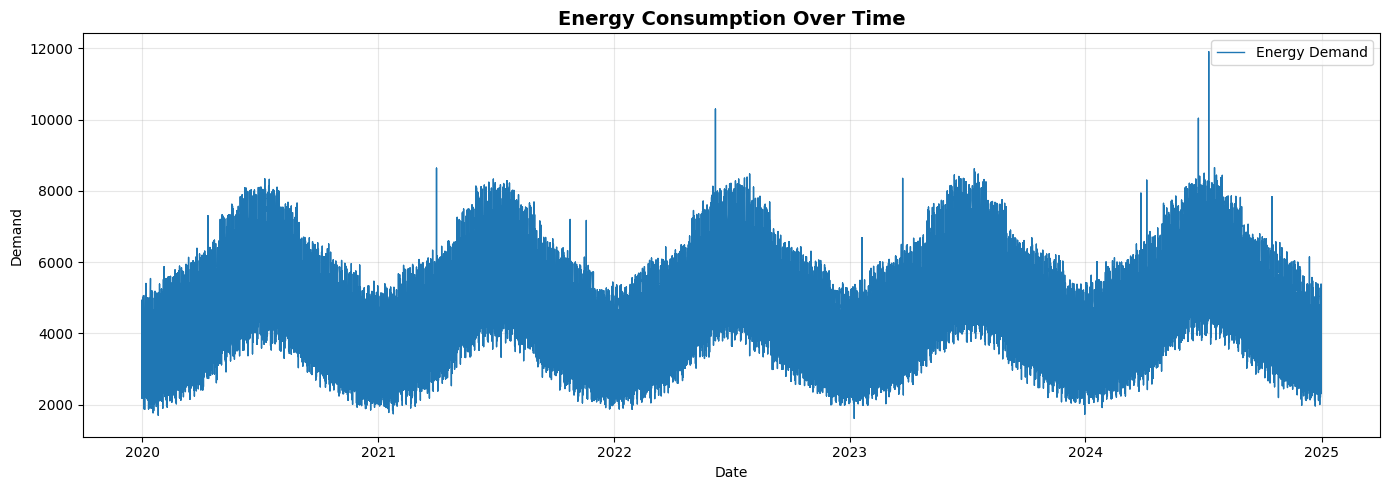

In [10]:
# ============ STEP 2: TIME SERIES VISUALIZATION ============
print("\n--- TIME SERIES VISUALIZATION ---")
plt.figure(figsize=(14, 5))
plt.plot(df.index, ts_data, label='Energy Demand', linewidth=1)
plt.title('Energy Consumption Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lstm_time_series_plot.png', dpi=300)
print("✓ Time series plot saved as 'lstm_time_series_plot.png'")
plt.show()

In [11]:
# ============ STEP 3: DATA NORMALIZATION ============
print("\n--- DATA NORMALIZATION ---")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(ts_data)

print(f"Original data range: {ts_data.min():.4f} - {ts_data.max():.4f}")
print(f"Scaled data range: {scaled_data.min():.4f} - {scaled_data.max():.4f}")
print("✓ Data normalized using MinMaxScaler")


--- DATA NORMALIZATION ---
Original data range: 1611.9540 - 11910.7051
Scaled data range: 0.0000 - 1.0000
✓ Data normalized using MinMaxScaler


In [20]:
scaled_data

array([[0.08206489],
       [0.09809335],
       [0.15548236],
       ...,
       [0.10783115],
       [0.31088584],
       [0.15604507]], shape=(43817, 1))

In [12]:
# ============ STEP 4: CREATE SEQUENCES FOR LSTM ============
print("\n--- CREATING SEQUENCES FOR LSTM ---")

# Lookback window (past 24 hours to predict next hour)
lookback = 24  # Use previous 24 hours to predict next hour
forecast_steps = 30 * 24  # 30 days * 24 hours = 720 hours

def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, lookback)
print(f"Input sequences shape (X): {X.shape}")
print(f"Target sequences shape (y): {y.shape}")

# Reshape X for LSTM [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
print(f"X reshaped for LSTM: {X.shape}")


--- CREATING SEQUENCES FOR LSTM ---
Input sequences shape (X): (43793, 24)
Target sequences shape (y): (43793,)
X reshaped for LSTM: (43793, 24, 1)


In [15]:
# ============ STEP 5: TRAIN-TEST SPLIT ============
print("\n--- TRAIN-TEST SPLIT ---")
# Use 80% for training, 20% for testing
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"Training set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing set: X_test {X_test.shape}, y_test {y_test.shape}")


--- TRAIN-TEST SPLIT ---
Training set: X_train (35034, 24, 1), y_train (35034,)
Testing set: X_test (8759, 24, 1), y_test (8759,)


In [17]:
# ============ STEP 6: BUILD LSTM MODEL ============
print("\n--- BUILDING LSTM MODEL ---")

model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(lookback, 1)),
    Dropout(0.2),
    
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    
    LSTM(units=25),
    Dropout(0.2),
    
    Dense(units=1)
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

print("✓ LSTM Model Architecture:")
print(model.summary())



--- BUILDING LSTM MODEL ---
✓ LSTM Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 25)             │         7,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,226 (149.32 KB)

 Trainable params: 38,226 (149.32 KB)

 Non-trainable params: 0 (0.00 B)

None


In [19]:
# ============ STEP 7: TRAIN LSTM MODEL ============
print("\n--- TRAINING LSTM MODEL ---")
print("Training in progress (this may take a few minutes)...\n")

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("\n✓ Model training completed!")


--- TRAINING LSTM MODEL ---
Training in progress (this may take a few minutes)...

Epoch 1/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - loss: 0.0029 - mae: 0.0385 - val_loss: 0.0027 - val_mae: 0.0374
Epoch 2/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - loss: 0.0028 - mae: 0.0381 - val_loss: 0.0027 - val_mae: 0.0361
Epoch 3/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 43s 49ms/step - loss: 0.0028 - mae: 0.0378 - val_loss: 0.0024 - val_mae: 0.0335
Epoch 4/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - loss: 0.0027 - mae: 0.0375 - val_loss: 0.0025 - val_mae: 0.0341
Epoch 5/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 43s 49ms/step - loss: 0.0027 - mae: 0.0370 - val_loss: 0.0023 - val_mae: 0.0324
Epoch 6/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - loss: 0.0026 - mae: 0.0365 - val_loss: 0.0022 - val_mae: 0.0310
Epoch 7/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 48s 55ms/step - loss: 0.0026 - mae: 0.0362 - val_loss: 0.0022 - val_mae: 0.0320
Epoch 8/15
876/876 ━━━━━━━━━━━━━━━━━━━━ 46s 52ms/step - loss: 0.0026 - mae: 

In [27]:
# ============ STEP : SAVE THE MODEL ============
# Use the native Keras format (.keras) for the most reliable saving
model_save_path = 'lstm_time_series_model.keras'
model.save(model_save_path)
print(f"Model successfully saved to: {model_save_path}")

Model successfully saved to: lstm_time_series_model.keras



--- TRAINING HISTORY ---
✓ Training history plot saved as 'lstm_training_history.png'


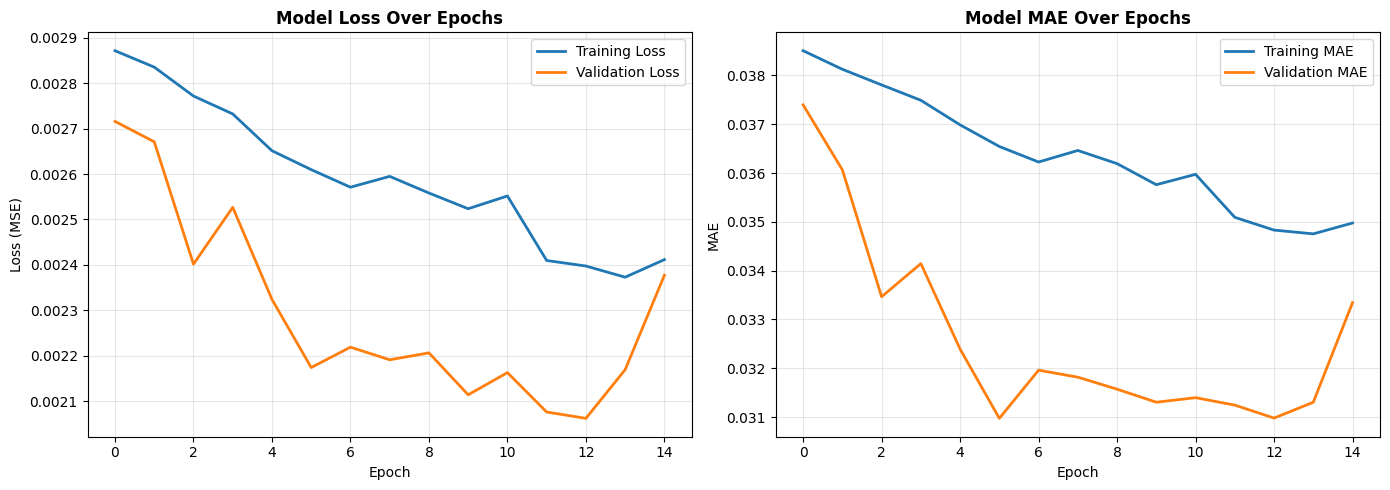

In [21]:
# ============ STEP 8: TRAINING HISTORY VISUALIZATION ============
print("\n--- TRAINING HISTORY ---")
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE', linewidth=2)
plt.plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
plt.title('Model MAE Over Epochs', fontsize=12, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_training_history.png', dpi=300)
print("✓ Training history plot saved as 'lstm_training_history.png'")
plt.show()

In [22]:
# ============ STEP 9: IN-SAMPLE PREDICTIONS ============
print("\n--- IN-SAMPLE PREDICTIONS ON TEST SET ---")

y_train_pred = model.predict(X_train, verbose=0)
y_test_pred = model.predict(X_test, verbose=0)

# Inverse transform to original scale
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_train_pred_actual = scaler.inverse_transform(y_train_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test_pred_actual = scaler.inverse_transform(y_test_pred)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train_actual, y_train_pred_actual))
train_mae = mean_absolute_error(y_train_actual, y_train_pred_actual)
train_r2 = r2_score(y_train_actual, y_train_pred_actual)

test_rmse = np.sqrt(mean_squared_error(y_test_actual, y_test_pred_actual))
test_mae = mean_absolute_error(y_test_actual, y_test_pred_actual)
test_r2 = r2_score(y_test_actual, y_test_pred_actual)

print("\nTraining Metrics:")
print(f"  RMSE: {train_rmse:.4f}")
print(f"  MAE:  {train_mae:.4f}")
print(f"  R²:   {train_r2:.4f}")

print("\nTesting Metrics:")
print(f"  RMSE: {test_rmse:.4f}")
print(f"  MAE:  {test_mae:.4f}")
print(f"  R²:   {test_r2:.4f}")


--- IN-SAMPLE PREDICTIONS ON TEST SET ---

Training Metrics:
  RMSE: 439.4143
  MAE:  301.7419
  R²:   0.9030

Testing Metrics:
  RMSE: 517.1900
  MAE:  340.9312
  R²:   0.8661



--- VISUALIZATION: ACTUAL VS PREDICTED ---
✓ Actual vs Predicted plot saved as 'lstm_actual_vs_predicted.png'


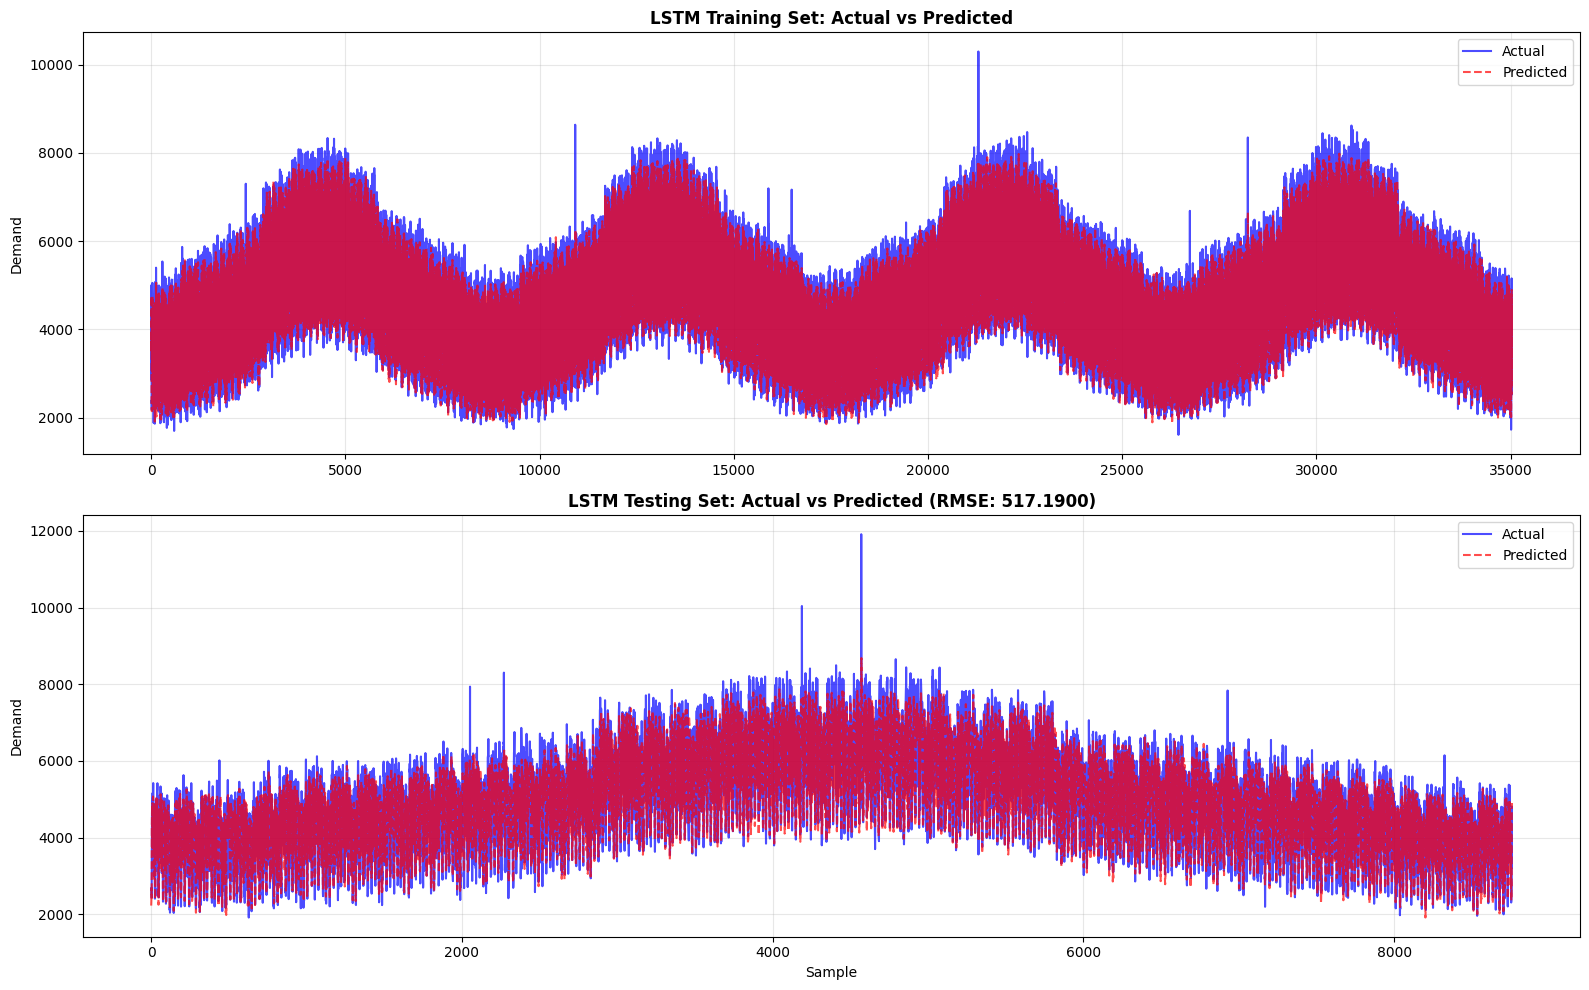

In [23]:
# ============ STEP 10: VISUALIZATION - ACTUAL VS PREDICTED ============
print("\n--- VISUALIZATION: ACTUAL VS PREDICTED ---")

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Training predictions
ax1 = axes[0]
ax1.plot(y_train_actual, 'b-', label='Actual', linewidth=1.5, alpha=0.7)
ax1.plot(y_train_pred_actual, 'r--', label='Predicted', linewidth=1.5, alpha=0.7)
ax1.set_title('LSTM Training Set: Actual vs Predicted', fontsize=12, fontweight='bold')
ax1.set_ylabel('Demand')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Testing predictions
ax2 = axes[1]
ax2.plot(y_test_actual, 'b-', label='Actual', linewidth=1.5, alpha=0.7)
ax2.plot(y_test_pred_actual, 'r--', label='Predicted', linewidth=1.5, alpha=0.7)
ax2.set_title(f'LSTM Testing Set: Actual vs Predicted (RMSE: {test_rmse:.4f})', fontsize=12, fontweight='bold')
ax2.set_xlabel('Sample')
ax2.set_ylabel('Demand')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_actual_vs_predicted.png', dpi=300)
print("✓ Actual vs Predicted plot saved as 'lstm_actual_vs_predicted.png'")
plt.show()


In [24]:
# ============ STEP 11: PREPARE DATA FOR 30-DAY FORECAST ============
print("\n--- PREPARING DATA FOR 30-DAY FORECAST ---")

# Use last lookback samples to start forecasting
last_sequence = scaled_data[-lookback:].reshape(1, lookback, 1)
print(f"Last sequence shape: {last_sequence.shape}")


--- PREPARING DATA FOR 30-DAY FORECAST ---
Last sequence shape: (1, 24, 1)


In [25]:
# ============ STEP 12: FORECAST NEXT 30 DAYS ============
print("\n--- FORECASTING NEXT 30 DAYS ---")
print(f"Generating {forecast_steps} hourly predictions (30 days)...\n")

forecast_predictions = []
current_sequence = last_sequence.copy()

for i in range(forecast_steps):
    # Predict next hour
    next_pred = model.predict(current_sequence, verbose=0)
    forecast_predictions.append(next_pred[0, 0])
    
    # Update sequence: remove first element, add prediction
    current_sequence = np.append(current_sequence[:, 1:, :], 
                                 next_pred.reshape(1, 1, 1), axis=1)
    
    if (i + 1) % 168 == 0:  # Print every week
        print(f"  Generated {i + 1}/{forecast_steps} predictions ({(i+1)/24:.1f} days)")

forecast_predictions = np.array(forecast_predictions).reshape(-1, 1)

# Inverse transform to original scale
forecast_actual = scaler.inverse_transform(forecast_predictions)

print(f"\n✓ 30-Day forecast completed!")
print(f"Forecast shape: {forecast_actual.shape}")


--- FORECASTING NEXT 30 DAYS ---
Generating 720 hourly predictions (30 days)...

  Generated 168/720 predictions (7.0 days)
  Generated 336/720 predictions (14.0 days)
  Generated 504/720 predictions (21.0 days)
  Generated 672/720 predictions (28.0 days)

✓ 30-Day forecast completed!
Forecast shape: (720, 1)


In [26]:
forecast_actual

array([[4746.332 ],
       [4786.454 ],
       [4757.0527],
       [4049.2185],
       [4193.965 ],
       [4024.8125],
       [3619.7278],
       [3207.561 ],
       [4574.464 ],
       [4536.5273],
       [3796.3196],
       [4400.789 ],
       [3038.7883],
       [2367.2786],
       [2243.554 ],
       [2378.478 ],
       [2632.808 ],
       [3638.006 ],
       [3981.7036],
       [4272.665 ],
       [4448.303 ],
       [3153.4846],
       [4528.9717],
       [3099.3894],
       [3444.836 ],
       [3986.5305],
       [4398.3516],
       [4585.7393],
       [4621.737 ],
       [4489.625 ],
       [4225.194 ],
       [4150.404 ],
       [3901.9858],
       [2901.1812],
       [4049.1714],
       [2317.2908],
       [1968.6013],
       [1963.7865],
       [2332.4355],
       [2473.3093],
       [4200.335 ],
       [3723.7563],
       [4156.123 ],
       [4325.063 ],
       [4332.0977],
       [3060.127 ],
       [4196.2007],
       [4207.079 ],
       [4273.9253],
       [4326.3555],



--- CREATING FORECAST DATAFRAME ---

Forecast DataFrame (First 10 rows):
                 Date     Forecast
0 2024-12-31 01:00:00  4746.332031
1 2024-12-31 02:00:00  4786.454102
2 2024-12-31 03:00:00  4757.052734
3 2024-12-31 04:00:00  4049.218506
4 2024-12-31 05:00:00  4193.964844
5 2024-12-31 06:00:00  4024.812500
6 2024-12-31 07:00:00  3619.727783
7 2024-12-31 08:00:00  3207.561035
8 2024-12-31 09:00:00  4574.463867
9 2024-12-31 10:00:00  4536.527344

Forecast DataFrame (Last 10 rows):
                   Date     Forecast
710 2025-01-29 15:00:00  4118.752441
711 2025-01-29 16:00:00  4082.345459
712 2025-01-29 17:00:00  3475.174561
713 2025-01-29 18:00:00  3700.675049
714 2025-01-29 19:00:00  3384.948730
715 2025-01-29 20:00:00  2896.490967
716 2025-01-29 21:00:00  2554.980225
717 2025-01-29 22:00:00  3601.390381
718 2025-01-29 23:00:00  3867.217773
719 2025-01-30 00:00:00  2584.094727

✓ Forecast saved to 'energy_forecast_30days_lstm.csv'

--- CREATING FORECAST VISUALIZATION ---
✓ 

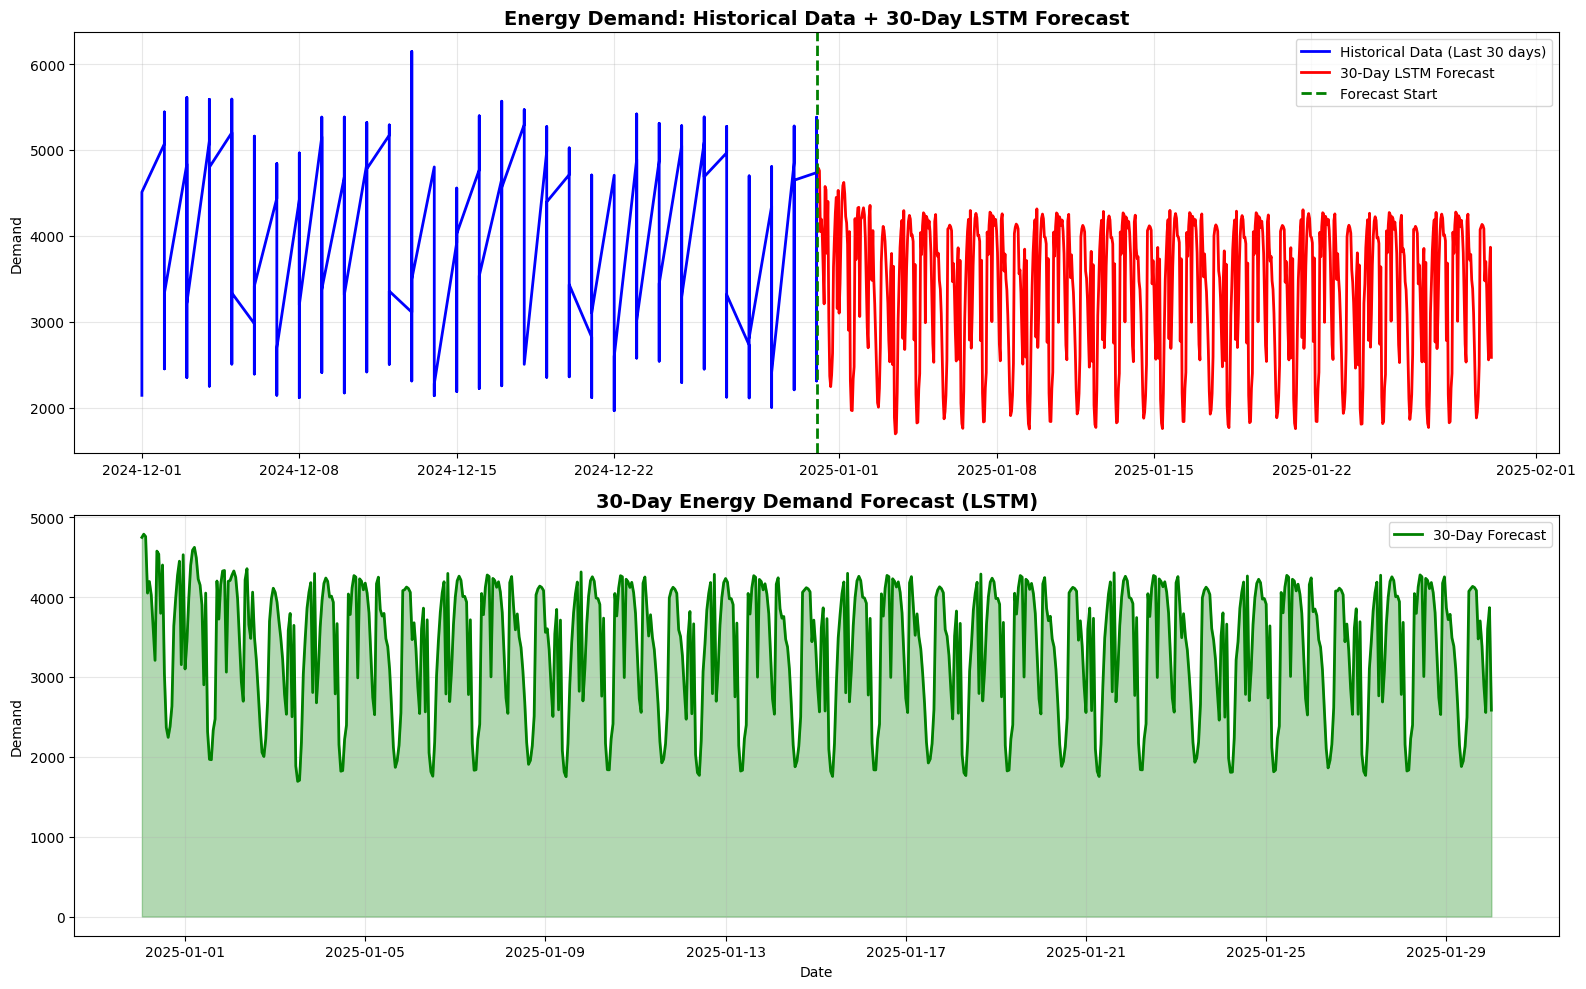

In [29]:
# ============ STEP 13: CREATE FORECAST DATAFRAME ============
print("\n--- CREATING FORECAST DATAFRAME ---")

# Generate future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(hours=1), 
                              periods=forecast_steps, freq='H')

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Forecast': forecast_actual.flatten()
})

print("\nForecast DataFrame (First 10 rows):")
print(forecast_df.head(10))

print("\nForecast DataFrame (Last 10 rows):")
print(forecast_df.tail(10))

# Save forecast to CSV
forecast_df.to_csv('energy_forecast_30days_lstm.csv', index=False)
print("\n✓ Forecast saved to 'energy_forecast_30days_lstm.csv'")

# ============ STEP 14: FORECAST VISUALIZATION ============
print("\n--- CREATING FORECAST VISUALIZATION ---")

fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Historical data + forecast
ax1 = axes[0]
ax1.plot(df.index[-720:], ts_data[-720:], 'b-', label='Historical Data (Last 30 days)', linewidth=2)
ax1.plot(forecast_df['Date'], forecast_df['Forecast'], 'r-', label='30-Day LSTM Forecast', linewidth=2)
ax1.axvline(x=df.index[-1], color='g', linestyle='--', linewidth=2, label='Forecast Start')
ax1.set_title('Energy Demand: Historical Data + 30-Day LSTM Forecast', fontsize=14, fontweight='bold')
ax1.set_ylabel('Demand')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Only forecast
ax2 = axes[1]
ax2.plot(forecast_df['Date'], forecast_df['Forecast'], 'g-', linewidth=2, label='30-Day Forecast')
ax2.fill_between(forecast_df['Date'], forecast_df['Forecast'], alpha=0.3, color='green')
ax2.set_title('30-Day Energy Demand Forecast (LSTM)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Demand')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('lstm_forecast_30days.png', dpi=300)
print("✓ Forecast visualization saved as 'lstm_forecast_30days.png'")
plt.show()

In [30]:
# ============ STEP 15: DAILY AGGREGATES ============
print("\n--- DAILY FORECAST SUMMARY ---")

forecast_df['Day'] = forecast_df['Date'].dt.date
daily_forecast = forecast_df.groupby('Day').agg({
    'Forecast': ['mean', 'min', 'max', 'sum', 'std']
}).round(2)

daily_forecast.columns = ['Mean_Demand', 'Min_Demand', 'Max_Demand', 'Total_Demand', 'Std_Demand']

print("\nDaily Forecast Summary (First 10 days):")
print(daily_forecast.head(10))

print("\nDaily Forecast Summary (Last 5 days):")
print(daily_forecast.tail(5))

# Save daily summary
daily_forecast.to_csv('energy_forecast_daily_summary_lstm.csv')
print("\n✓ Daily summary saved to 'energy_forecast_daily_summary_lstm.csv'")



--- DAILY FORECAST SUMMARY ---

Daily Forecast Summary (First 10 days):
            Mean_Demand   Min_Demand   Max_Demand  Total_Demand  Std_Demand
Day                                                                        
2024-12-31  3799.010010  2243.550049  4786.450195  87377.273438  826.530029
2025-01-01  3620.969971  1963.790039  4621.740234  86903.273438  874.440002
2025-01-02  3438.909912  2003.839966  4354.479980  82533.742188  781.859985
2025-01-03  3173.850098  1693.069946  4293.810059  76172.500000  795.340027
2025-01-04  3540.040039  1820.119995  4268.180176  84960.929688  852.659973
2025-01-05  3333.719971  1868.449951  4248.310059  80009.343750  811.150024
2025-01-06  3190.560059  1757.459961  4295.189941  76573.382812  758.969971
2025-01-07  3575.959961  1832.150024  4275.649902  85822.976562  864.229980
2025-01-08  3329.979980  1905.979980  4256.439941  79919.476562  798.650024
2025-01-09  3180.659912  1751.099976  4313.799805  76335.750000  754.929993

Daily Forecast

In [31]:
# ============ STEP 16: SUMMARY REPORT ============
print("\n" + "="*70)
print("LSTM FORECAST SUMMARY - NEXT 30 DAYS")
print("="*70)
print(f"\nModel Configuration:")
print(f"  Lookback window: {lookback} hours")
print(f"  LSTM Layers: 3")
print(f"  Units: [50, 50, 25]")
print(f"  Dropout: 0.2")
print(f"  Optimizer: Adam (learning_rate=0.001)")
print(f"  Total Parameters: {model.count_params()}")

print(f"\nTraining Performance:")
print(f"  Training RMSE: {train_rmse:.4f}")
print(f"  Training MAE: {train_mae:.4f}")
print(f"  Training R²: {train_r2:.4f}")

print(f"\nTesting Performance:")
print(f"  Testing RMSE: {test_rmse:.4f}")
print(f"  Testing MAE: {test_mae:.4f}")
print(f"  Testing R²: {test_r2:.4f}")

print(f"\n30-Day Forecast Statistics:")
print(f"  Average Daily Demand: {daily_forecast['Mean_Demand'].mean():.2f}")
print(f"  Total 30-Day Demand: {daily_forecast['Total_Demand'].sum():.2f}")
print(f"  Forecast Range: {forecast_actual.min():.2f} - {forecast_actual.max():.2f}")
print(f"  Average Daily Std Dev: {daily_forecast['Std_Demand'].mean():.2f}")

print("\n" + "="*70)
print("✓ LSTM 30-Day Forecast Completed Successfully!")
print("="*70)
print("\nGenerated Files:")
print("  1. energy_forecast_30days_lstm.csv - Hourly predictions")
print("  2. energy_forecast_daily_summary_lstm.csv - Daily aggregates")
print("  3. lstm_forecast_30days.png - Forecast visualization")
print("  4. lstm_actual_vs_predicted.png - Model predictions comparison")
print("  5. lstm_training_history.png - Training history")
print("  6. lstm_time_series_plot.png - Original time series")


LSTM FORECAST SUMMARY - NEXT 30 DAYS

Model Configuration:
  Lookback window: 24 hours
  LSTM Layers: 3
  Units: [50, 50, 25]
  Dropout: 0.2
  Optimizer: Adam (learning_rate=0.001)
  Total Parameters: 38226

Training Performance:
  Training RMSE: 439.4143
  Training MAE: 301.7419
  Training R²: 0.9030

Testing Performance:
  Testing RMSE: 517.1900
  Testing MAE: 340.9312
  Testing R²: 0.8661

30-Day Forecast Statistics:
  Average Daily Demand: 3351.21
  Total 30-Day Demand: 2430065.50
  Forecast Range: 1693.07 - 4786.45
  Average Daily Std Dev: 813.23

✓ LSTM 30-Day Forecast Completed Successfully!

Generated Files:
  1. energy_forecast_30days_lstm.csv - Hourly predictions
  2. energy_forecast_daily_summary_lstm.csv - Daily aggregates
  3. lstm_forecast_30days.png - Forecast visualization
  4. lstm_actual_vs_predicted.png - Model predictions comparison
  5. lstm_training_history.png - Training history
  6. lstm_time_series_plot.png - Original time series
